# Analiza wyników

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from itertools import product

from simulation import run_simulation

%matplotlib inline
sns.set(style="whitegrid")

In [74]:
n_simulations = 1000
plot_saving_mode = True

## Scenariusz bazowy

In [3]:
results_normal, _ = run_simulation(n_simulations=1000)

In [4]:
print("średni dochód: " + str(results_normal.mean()))
print("odchylenie z dochodu: " + str(results_normal.std()))

średni dochód: 178.082841842
odchylenie z dochodu: 125.641116461


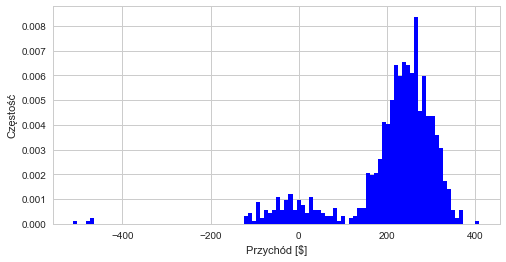

In [75]:
plt.figure(figsize = (8, 4))
plt.hist(results_normal, bins=100, density = True, color = 'blue')
plt.ylabel("Częstość")
plt.xlabel("Przychód [$]")
if plot_saving_mode:
    plt.savefig('raport/wykresy/histogram.pdf')
else:
    plt.show()

## Ilu barmanów zatrudnić

Opakowalem w funkcje i dodalem macierz rozwiazan optymalnych.
Jako params mozna podac slownik postaci argument: wartosc do przekazania do run_simulation. W ten sposob mozna analizowac rozwiazanie optymalne dla alternatywnych scenariuszy.
Porownalem z poprzednim kodem - nie powinno byc rozbieznosci w wynikach

In [5]:
def find_opt_solution(max_male, max_female, params = {'n_simulations': 200}):
    bartender_results = np.zeros((max_male+1, max_female+1))
    
    for i in tqdm.tqdm( product( np.arange(max_male+1), np.arange(max_female+1) ) ):
            # creating unique combination of male and female bartenders
            params['bartenders'] = [False] * i[0] + [True] * i[1]
            #running simulation
            results, _ = run_simulation(**params)
            #appending results
            bartender_results[i] = results.mean()
            
    path_matrix = np.zeros((max_male + 1, max_female + 1))
    optimum = 0
    diags = [bartender_results[::-1,:].diagonal(i) for i in range(1-bartender_results.shape[0], bartender_results.shape[1])]
    
    for i, x in enumerate(diags):
        i0 = min(i, path_matrix.shape[0]-1) - x.argmax()
        i1 = i-i0
        path_matrix[i0, i1] = x.max() - optimum
        optimum = x.max()
    return bartender_results, path_matrix

In [9]:
np.save('results_standard', bartender_results)
np.save('path_standard', path_matrix)

In [6]:
bartender_results, path_matrix = find_opt_solution(10, 10, {'n_simulations': 1000})

121it [17:46, 10.16s/it]


Wyniki zapisane dla 1000 iteracji

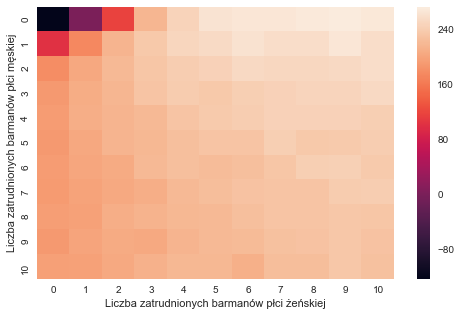

In [76]:
plt.figure(figsize = (8, 5))
sns.heatmap(bartender_results)
plt.ylabel("Liczba zatrudnionych barmanów płci męskiej")
plt.xlabel("Liczba zatrudnionych barmanów płci żeńskiej")
if plot_saving_mode:
    plt.savefig('raport/wykresy/barmani.pdf')
else:
    plt.show()

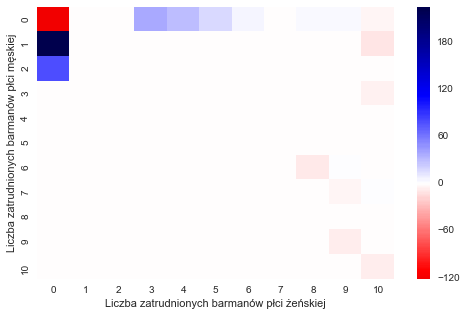

In [84]:
plt.figure(figsize = (8,5))
sns.set(style = 'whitegrid')
sns.heatmap(path_matrix, cmap = 'seismic_r', center = 0)
plt.ylabel("Liczba zatrudnionych barmanów płci męskiej")
plt.xlabel("Liczba zatrudnionych barmanów płci żeńskiej")
if plot_saving_mode:
    plt.savefig('raport/wykresy/opt_sciezka.pdf')
else:
    plt.show()

Powyższa mapka pokazuje, która kombinacja jest optymalna przy założeniu, że zatrudniamy n barmanów (optymalne rozwiązania przy założeniu równych płac). Niebieski pokazuje wzrost średniego zysku względem n-1 barmanów, czerwony to spadek. Bialy oznacza 0, czyli kombinacje nieoptymalne (na przyklad (0,1), bo lepiej jako pierwszego barmana zatrudnic faceta niz kobiete.

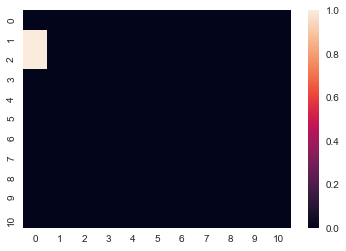

In [15]:
sns.heatmap(path_matrix > 40)

Przyjmijmy, ze placa minimalna wynosi 40 USD za dobę (4 USD/h). Wtedy optimum to 2 barmanów (mężczyźni)

In [35]:
indices = np.array((path_matrix > 40).nonzero())
indices.sum(axis = 0).argmax()
(indices[:,1] == np.array([2,0])).all()

True

Z uwagi na niewielkie dalsze przyrosty ograniczmy maksymalną liczbę barmanów i barmanek do 6.

# Analiza wrażliwości

## Zatrudnianie ładniejszych kelnerek

In [63]:
n_simulations = 1000
bartenders_opt = [True, True, True]

Przyjmijmy, że wzrost czasu flirtu o 3 minuty przekłada się na napiwek wyższy o 50 centów

In [64]:
results_normal, _ = run_simulation(n_simulations=n_simulations,
                                   bartenders = bartenders_opt)
results_beautiful, _ = run_simulation(n_simulations=n_simulations,
                                      bartenders = bartenders_opt,
                                      flirt_time=25,
                                      avg_tip=5)

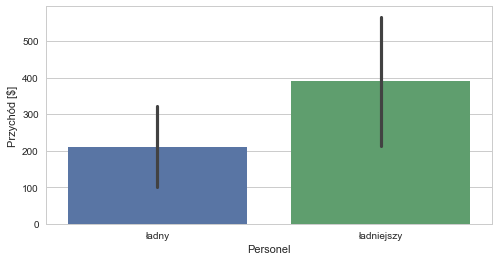

In [78]:
plt.figure(figsize=(8,4))
df_to_plot = pd.DataFrame(
    {
        "Personel": 
            ["ładny"] * n_simulations + ["ładniejszy"] * n_simulations,
        "Przychód [$]": np.concatenate((results_normal, results_beautiful), axis=0)
    }
)
ax = sns.barplot(x="Personel", y="Przychód [$]", data=df_to_plot, ci="sd")
if plot_saving_mode:
    plt.savefig('raport/wykresy/personel.pdf')
else:
    plt.show()

In [67]:
print("średni przychód ładna: " + str(results_normal.mean()))
print("średni przychód ładniejsza: " + str(results_beautiful.mean()))

print("odchylenie ładna: " + str(results_normal.std()))
print("odchylenie ładniejsza: " + str(results_beautiful.std()))

średni przychód ładna: 211.31039524
średni przychód ładniejsza: 389.298337458
odchylenie ładna: 110.170885278
odchylenie ładniejsza: 177.133236569


Przykład: rozwiazanie optymalne przy ladniejszych kelnerkach:

In [ ]:
bartender_results_pretty, path_matrix_pretty = find_opt_solution(10, 10, {'n_simulations': n_simulations,
                                                           'flirt_time':25, 'avg_tip':5})





0it [00:00, ?it/s]



1it [00:01,  1.76s/it]



2it [00:05,  2.45s/it]



3it [00:10,  3.25s/it]



4it [00:18,  4.48s/it]



5it [00:28,  6.17s/it]



6it [00:36,  6.70s/it]



7it [00:43,  6.96s/it]



8it [00:54,  7.95s/it]



9it [01:05,  8.92s/it]



10it [01:14,  9.11s/it]



11it [01:22,  8.74s/it]



12it [01:28,  7.94s/it]



13it [01:39,  8.81s/it]



14it [01:48,  8.85s/it]



15it [01:57,  8.99s/it]



16it [02:05,  8.60s/it]



17it [02:13,  8.24s/it]



18it [02:21,  8.19s/it]



19it [02:29,  8.36s/it]



20it [02:37,  8.23s/it]



21it [02:45,  8.10s/it]



22it [02:53,  8.19s/it]



23it [03:01,  8.00s/it]



24it [03:09,  8.12s/it]



25it [03:17,  8.05s/it]



26it [03:27,  8.43s/it]



27it [03:36,  8.58s/it]



28it [03:45,  8.93s/it]



29it [03:54,  8.81s/it]



30it [04:04,  9.21s/it]



31it [04:19, 10.82s/it]



32it [04:29, 10.81s/it]



33it [04:39, 10.44s/it]



34it [04:46,  9.40s/it]



35it [04:53,  8.81s/it]



36it [05:00,  8.31s/it]



37it [05:09

In [ ]:
plt.figure(figsize = (8, 5))
sns.heatmap(bartender_results)
plt.ylabel("Liczba zatrudnionych barmanów płci męskiej")
plt.xlabel("Liczba zatrudnionych barmanów płci żeńskiej")
if plot_saving_mode:
    plt.savefig('raport/wykresy/barmani_ladni.pdf')
else:
    plt.show()

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(path_matrix, cmap = 'seismic_r', center = 0)
plt.ylabel("Liczba zatrudnionych barmanów płci męskiej")
plt.xlabel("Liczba zatrudnionych barmanów płci żeńskiej")
if plot_saving_mode:
    plt.savefig('raport/wykresy/opt_sciezka_ladni.pdf')
else:
    plt.show()

Widac, ze w przypadku ladniejszych kelnerek szybciej i bardziej ewidentnie oplaca sie zaczac je zatrudniac

## Zajęcie w kolejce

In [68]:
patience_results = np.zeros(11)
patience_std = np.zeros(11)

for patience in tqdm.tqdm(range(len(patience_results))):
    results, _ = run_simulation(n_simulations=int(n_simulations), patience_threshold=patience)
    patience_results[patience] = results.mean()
    patience_std[patience] = results.std()



  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

  9%|███████▌                                                                           | 1/11 [00:04<00:42,  4.24s/it]

 18%|███████████████                                                                    | 2/11 [00:08<00:38,  4.24s/it]

 27%|██████████████████████▋                                                            | 3/11 [00:14<00:37,  4.63s/it]

 36%|██████████████████████████████▏                                                    | 4/11 [00:18<00:32,  4.68s/it]

 45%|█████████████████████████████████████▋                                             | 5/11 [00:24<00:30,  5.04s/it]

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:32<00:29,  5.91s/it]

 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:38<00:23,  5.92s/it]

 73%|█████████████████████████

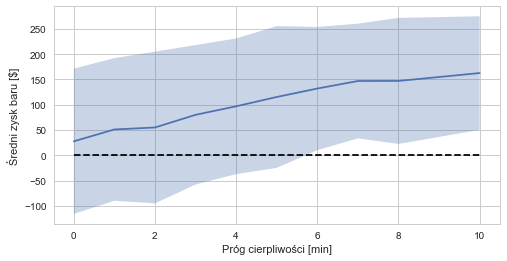

In [81]:
plt.figure(figsize = (8,4))
plt.fill_between(np.arange(0, 11), y1 = patience_results - patience_std,
                 y2 = patience_results + patience_std,
                alpha = 0.3)
plt.plot(patience_results)
plt.hlines(y = 0, xmin = 0, xmax = 10, linestyle = 'dashed')
plt.xlabel('Próg cierpliwości [min]')
plt.ylabel('Średni zysk baru [$]')
if plot_saving_mode:
    plt.savefig('raport/wykresy/zajecie_w_kolejce.pdf')
else:
    plt.show()

## Lepszy wystrój, więcej klientów, wyższa strata

In [72]:
decor_results = np.zeros(20)
decor_ccount = np.zeros(20) # customer count for illustration purposes

for decor in tqdm.tqdm(range(1, len(decor_results))):
    results, histories = run_simulation(
        n_simulations=n_simulations,
        bartenders = bartenders_opt,
        shootout_loss=20*decor, 
        customer_lambda=(45 - 2*decor)) # decor must have a negative parameter here to increase customer count
    decor_results[decor] = results.mean()
    decor_ccount[decor] = np.mean([[x[1:3] for x in history].count(('Customer_choice', 'new')) for history in histories])





  0%|                                                                                           | 0/19 [00:00<?, ?it/s]



  5%|████▎                                                                              | 1/19 [00:04<01:16,  4.25s/it]



 11%|████████▋                                                                          | 2/19 [00:08<01:12,  4.28s/it]



 16%|█████████████                                                                      | 3/19 [00:13<01:10,  4.38s/it]



 21%|█████████████████▍                                                                 | 4/19 [00:17<01:04,  4.28s/it]



 26%|█████████████████████▊                                                             | 5/19 [00:22<01:04,  4.62s/it]



 32%|██████████████████████████▏                                                        | 6/19 [00:29<01:08,  5.29s/it]



 37%|██████████████████████████████▌                                                    | 7/19 [00:35<01:07,  5.58s/it]



 42%|███████

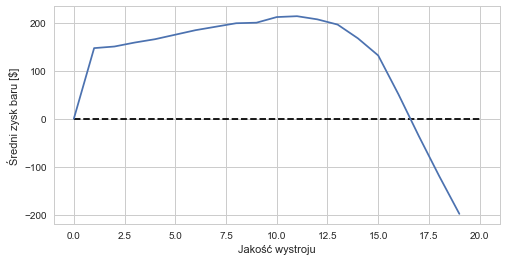

In [82]:
plt.figure(figsize = (8,4))
plt.plot(decor_results)
plt.xlabel('Jakość wystroju')
plt.ylabel('Średni zysk baru [$]')
plt.hlines(y = 0, xmin = 0, xmax = 20, linestyle = 'dashed')
if plot_saving_mode:
    plt.savefig('raport/wykresy/wystroj.pdf')
else:
    plt.show()

# Unused scenarios

# Strzelaniny

Na chwilę obecną rośnie tylko prawdopodobieństwo strzelaniny przy pokerze. To w kolejce pozostaje niezmienione. Można nim manipulować poprzez argumenty p_min_queue_shootout oraz p_queue_shootout - od pewnego momentu rosnie ono liniowo.

In [10]:
results_faster_shootout, _ = run_simulation(n_simulations=n_simulations, p_lost_everything=0.05)
results_normal_shootout, _ = run_simulation(n_simulations=n_simulations)
results_slower_shootout, _ = run_simulation(n_simulations=n_simulations, p_lost_everything=0.01)

In [11]:
print("średnia:")
print("szybciej strzelaniny: " + str(results_faster_shootout.mean()))
print("normalne strzelaniny: " + str(results_normal_shootout.mean()))
print("wolniejsze strzelaniny: " + str(results_slower_shootout.mean()))

średnia:
szybciej strzelaniny: 136.419383536
normalne strzelaniny: 186.088441689
wolniejsze strzelaniny: 182.391624272


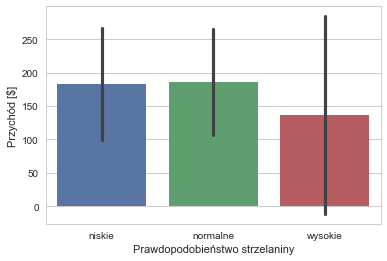

In [12]:
plt.figure(figsize=(8,4))
f, axes = plt.subplots(1, 1)
df_to_plot = pd.DataFrame(
    {
        "Prawdopodobieństwo strzelaniny": 
            ["niskie"] * n_simulations + 
            ["normalne"] * n_simulations + 
            ["wysokie"] * n_simulations,
        "Przychód [$]": np.concatenate((results_slower_shootout, results_normal_shootout, results_faster_shootout), axis=0)
    }
)
ax = sns.barplot(x="Prawdopodobieństwo strzelaniny", y="Przychód [$]", data=df_to_plot, ci="sd")
if plot_saving_mode:
    plt.savefig('raport/wykresy/p_strzelaniny.pdf')
else:
    plt.show()

In [13]:
df = pd.DataFrame.from_dict(bartender_results).T

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,10
0,-138.281949,106.193821,173.061466,176.992663,202.640000,189.637568,211.560000,207.880000,170.808455,186.719903,173.199768
1,10.366490,157.712497,220.670980,200.568516,208.450807,216.931579,195.896939,198.162445,185.411617,213.655393,205.329226
2,107.083832,209.391784,213.495647,206.218194,207.884478,221.511861,212.572975,212.274586,209.949722,188.769791,199.943321
3,195.787219,231.267011,235.491113,222.217317,226.635371,210.410524,227.931967,228.341244,205.675967,199.570292,190.619621
4,250.389525,244.944162,234.019593,236.935518,241.473807,221.918684,212.376518,187.367319,217.276378,240.282952,216.523591
5,229.285820,246.734496,236.087339,218.097313,229.073081,229.142203,241.663541,239.767197,249.384663,180.734979,209.624278
6,269.555785,261.305217,264.229555,252.356687,245.254427,231.242092,236.801274,219.009569,244.054355,216.707962,203.474825
7,267.902594,268.296890,244.432038,250.929541,234.498490,249.006882,250.197660,250.291099,244.226321,213.595962,223.662610
8,268.014727,251.414146,259.034356,257.939825,226.960263,250.077795,224.177264,245.539014,240.376584,233.280955,227.686619
9,239.054322,230.739463,254.922424,213.840464,258.397778,222.948871,234.974908,241.236274,252.143812,231.454167,231.999276


In [15]:
df.loc[:,0] / df.loc[:,2]

0    -0.799034
1     0.046977
2     0.501574
3     0.831400
4     1.069951
5     0.971191
6     1.020158
7     1.096021
8     1.034669
9     0.937753
10    0.986245
dtype: float64

In [16]:
df.loc[:,0] / df.loc[:,3]

0    -0.781286
1     0.051686
2     0.519274
3     0.881062
4     1.056783
5     1.051301
6     1.068154
7     1.067641
8     1.039059
9     1.117910
10    1.096211
dtype: float64

## Jaka strategia cenowa

In [17]:
results_expensive, _ = run_simulation(n_simulations=n_simulations, drink_price=4, patience_threshold=10)
results_cheap, _ = run_simulation(n_simulations=n_simulations)
results_super_cheap, _ = run_simulation(
    n_simulations=n_simulations,
    drink_price=1,
    patience_threshold=20,
    customer_lambda=10)

In [18]:
print("średnia:")
print("droższe drinki: " + str(results_expensive.mean()))
print("tańsze drinki: " + str(results_cheap.mean()))
print("super tanie drinki: " + str(results_super_cheap.mean()))

print("\nodchylenie:")
print("droższe drinki: " + str(results_expensive.std()))
print("tańsze drinki: " + str(results_cheap.std()))
print("super tanie drinki: " + str(results_super_cheap.std()))

średnia:
droższe drinki: 338.505185493
tańsze drinki: 170.828579627
super tanie drinki: -71.6820202581

odchylenie:
droższe drinki: 128.293481972
tańsze drinki: 132.584254526
super tanie drinki: 140.547887417


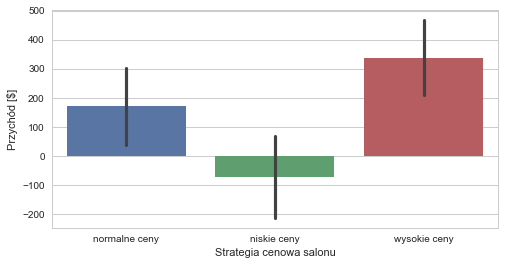

In [19]:
plt.figure(figsize=(8, 4))
df_to_plot = pd.DataFrame(
    {
        "Strategia cenowa salonu": 
            ["normalne ceny"] * n_simulations + 
            ["niskie ceny"] * n_simulations + 
            ["wysokie ceny"] * n_simulations,
        "Przychód [$]": np.concatenate((results_cheap, results_super_cheap, results_expensive), axis=0)
    }
)
ax = sns.barplot(x="Strategia cenowa salonu", y="Przychód [$]", data=df_to_plot, ci="sd")
if plot_saving_mode:
    plt.savefig('raport/wykresy/drinki.pdf')
else:
    plt.show()

# Większe stoły do pokera

In [30]:
results_normal, _ = run_simulation(n_simulations=n_simulations)
results_1, _ = run_simulation(n_simulations=n_simulations, poker_table_size=6, poker_length=15)
results_2, _ = run_simulation(n_simulations=n_simulations, poker_table_size=7, poker_length=20)
results_3, _ = run_simulation(n_simulations=n_simulations, poker_table_size=8, poker_length=25)

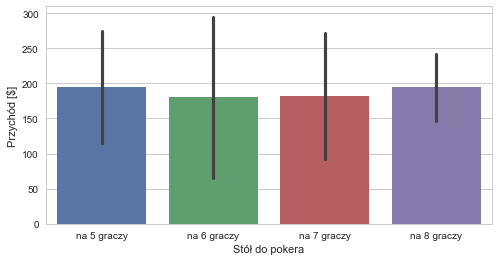

In [31]:
plt.figure(figsize=(8,4))
df_to_plot = pd.DataFrame(
    {
        "Stół do pokera": 
            ["na 5 graczy"] * n_simulations + ["na 6 graczy"] * n_simulations + ["na 7 graczy"] * n_simulations + ["na 8 graczy"] * n_simulations,
        "Przychód [$]": np.concatenate((results_normal, results_1, results_2, results_3), axis=0)
    }
)
sns.barplot(x="Stół do pokera", y="Przychód [$]", data=df_to_plot, ci="sd")
if plot_saving_mode:
    plt.savefig('raport/wykresy/poker.pdf')
else:
    plt.show()

In [32]:
print("średni przychód normal: " + str(results_normal.mean()))
print("średni przychód 1: " + str(results_1.mean()))
print("średni przychód 2: " + str(results_2.mean()))
print("średni przychód 3: " + str(results_3.mean()))

print("odchylenie normal: " + str(results_normal.std()))
print("odchylenie przychód 1: " + str(results_1.std()))
print("odchylenie przychód 2: " + str(results_2.std()))
print("odchylenie przychód 3: " + str(results_3.std()))

średni przychód normal: 194.560337453
średni przychód 1: 180.40965068
średni przychód 2: 181.871434559
średni przychód 3: 194.582224652
odchylenie normal: 79.5907566504
odchylenie przychód 1: 114.595885481
odchylenie przychód 2: 89.4382129713
odchylenie przychód 3: 47.7444259857
